# Load Libraries

In [442]:
import pandas as pd
import numpy as np
import csv
import re


In [443]:
csv_path = '/Users/amulya/Desktop/Elsewhere/me/Work/Hackathons/Numhack/Temperature-and-Coral-Bleaching/Data/coral.csv'


# Initial Analysis

In [444]:
# Read the CSV file
try:
    df = pd.read_csv(
        csv_path,
        na_values=['nd'],       # Replace 'nd' with NaN
        keep_default_na=True,   # Keep default NaN values
        quotechar='"',          # Character used to denote the start and end of a quoted item
        escapechar='\\',        # Character used to escape the quotechar inside a quoted item
        encoding='utf-8',       # Ensure proper encoding
        engine='python',        # Use the Python engine for better flexibility with malformed files
        on_bad_lines='warn'     # Warn about bad lines
    )
    print("CSV file loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")

CSV file loaded successfully.


In [445]:
print("Initial DataFrame:")
df.head()

Initial DataFrame:


,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Reef_ID,Realm_Name,Ecoregion_Name,Country_Name,...,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Date,Site_Comments,Sample_Comments,Bleaching_Comments
0,2501,10324336,Donner,23.16,-82.53,Atlantic,NaN,Tropical Atlantic,Cuba and Cayman Islands,Cuba,...,5.00,0.00,0.00,0.74,7.25,0.18,2005-09-15,NaN,NaN,NaN
1,3467,10324754,Donner,-17.57,-149.78,Pacific,NaN,Eastern Indo-Pacific,Society Islands French Polynesia,French Polynesia,...,4.00,0.00,0.26,0.67,4.65,0.19,1991-03-15,The bleaching does not appear to have gained ...,The bleaching does not appear to have gained ...,NaN
2,1794,10323866,Donner,18.37,-64.56,Atlantic,NaN,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United Kingdom,...,7.00,0.00,0.00,1.04,11.66,0.26,2006-01-15,NaN,NaN,NaN
3,8647,10328028,Donner,17.76,-64.57,Atlantic,NaN,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,4.00,0.00,0.00,0.75,5.64,0.20,2006-04-15,NaN,NaN,NaN
4,8648,10328029,Donner,17.77,-64.58,Atlantic,NaN,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,5.00,0.00,0.00,0.92,6.89,0.25,2006-04-15,NaN,NaN,NaN


In [446]:
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                28821 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41358 non-null  object 
 9   Country_Name                           41360 non-null  object 
 10  State_Island_Province_Name             41262 non-null

In [447]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [448]:
summary(df).style.background_gradient(cmap='YlOrBr')

data shape: (41361, 62)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
Site_ID,int64,0,0.000000,12702,1.000000,1000060.000000,74558.164793,252041.802612,2501,3467,1794
Sample_ID,int64,0,0.000000,27005,9623.000000,10331713.000000,10128797.707817,1373151.378025,10324336,10324754,10323866
Data_Source,object,0,0.000000,9,nan,nan,nan,nan,Donner,Donner,Donner
Latitude_Degrees,float64,0,0.000000,11066,-30.262500,36.750000,7.558085,15.732185,23.163000,-17.575000,18.369000
Longitude_Degrees,float64,0,0.000000,11025,-179.974300,179.964500,34.966127,103.404598,-82.526000,-149.783300,-64.564000
Ocean_Name,object,0,0.000000,5,nan,nan,nan,nan,Atlantic,Pacific,Atlantic
Reef_ID,object,12540,30.318416,5354,nan,nan,nan,nan,nan,nan,nan
Realm_Name,object,0,0.000000,9,nan,nan,nan,nan,Tropical Atlantic,Eastern Indo-Pacific,Tropical Atlantic
Ecoregion_Name,object,3,0.007253,114,nan,nan,nan,nan,Cuba and Cayman Islands,Society Islands French Polynesia,Hispaniola Puerto Rico and Lesser Antilles
Country_Name,object,1,0.002418,90,nan,nan,nan,nan,Cuba,French Polynesia,United Kingdom


# Processing

## Dropping unimportant columns

| **Column Name**                     | **Reason for Removal**                                                                                                                                                    |
|-------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Site_ID                             | Irrelevant for analysis; only used as a unique identifier for the site.                                                                                                  |
| Sample_ID                           | Irrelevant for analysis; only used as a unique identifier for the sampling event.                                                                                        |
| Data_Source                         | Not needed for current analysis, relates to metadata about how data was collected.                                                                                       |
| Reef_ID                             | Redundant identifier, same purpose as Site_ID.                                                                                                                           |
| Country_Name                        | Geographical information is already sufficiently captured by latitude, longitude, and ocean name variables.                                                              |
| State_Island_Province_Name           | Detailed geographical information not required for the analysis.                                                                                                         |
| City_Town_Name                      | Too granular geographical information for the intended analysis.                                                                                                         |
| Site_Name                           | Redundant with Site_ID; not needed for analysis.                                                                                                                         |
| Date_Day                            | Date is captured sufficiently by the full date column (Date).                                                                                                            |
| Date_Month                          | Date is captured sufficiently by the full date column (Date).                                                                                                            |
| Date_Year                           | Date is captured sufficiently by the full date column (Date).                                                                                                            |
| Substrate_Name                      | Not relevant for current analysis; relates to the type of substrate, which may not impact the focus of the study.                                                        |
| Temperature_Minimum                 | Detailed temperature variation (minimum) not required for the analysis.                                                                                                  |
| Temperature_Kelvin_Standard_Deviation | Standard deviation for temperature in Kelvin is not essential; focusing on Celsius values for analysis.                                                                  |
| SSTA_Standard_Deviation             | Not required; mean, minimum, and maximum values provide sufficient detail on SST anomalies.                                                                              |
| SSTA_Minimum                        | Not critical for analysis as the mean and maximum values of SSTA provide sufficient information.                                                                         |
| SSTA_FrequencyMax                   | Focusing on other SSTA-related variables (e.g., frequency and mean) makes this variable redundant.                                                                       |
| SSTA_DHW_Standard_Deviation         | Not critical for analysis; mean values and maximum provide sufficient details about degree heating weeks.                                                               |
| SSTA_DHWMax                         | Maximum values are not needed, as mean values of SSTA_DHW are sufficient for analysis.                                                                                   |
| SSTA_DHWMean                        | Other variables related to SSTA_DHW provide more relevant information for the analysis.                                                                                  |
| SSTA_Frequency_Standard_Deviation    | Not essential for analysis; mean frequency values are sufficient.                                                                                                       |
| SSTA_FrequencyMean                  | Other variables related to SSTA frequency provide sufficient detail.                                                                                                    |
| TSA_Standard_Deviation              | Standard deviation for TSA is not critical; mean, max, and minimum values are sufficient.                                                                                |
| TSA_Minimum                         | Minimum TSA value is not as relevant as mean and maximum values for analysis.                                                                                            |
| TSA_Frequency_Standard_Deviation    | Too granular for current analysis; focusing on mean and maximum frequency values instead.                                                                                |
| TSA_FrequencyMean                   | Other TSA-related variables provide sufficient information for analysis.                                                                                                |
| TSA_FrequencyMax                    | Maximum TSA frequency is not required as other TSA frequency variables are already included.                                                                             |
| TSA_DHW_Standard_Deviation          | Not essential; other TSA_DHW values (e.g., mean and maximum) are more relevant for the analysis.                                                                         |
| TSA_DHWMax                          | Not required for the analysis as other TSA_DHW-related variables provide sufficient information.                                                                         |
| TSA_DHWMean                         | Sufficient information is provided by other TSA_DHW-related variables.                                                                                                   |
| Site_Comments                       | Not required for the analysis as it's purely additional notes and does not impact core data.                                                                             |
| Bleaching_Comments                  | Not needed for the analysis as it contains extra information not directly related to the numerical analysis.                                                             |
| Sample_Comments                     | Extra information not relevant for the analysis.                                                                                                                        |
| ClimSST                             | Not necessary for the analysis; focus on other SST-related variables provides sufficient information.                                                                   |
| SSTA_Mean                           | Redundant information; other SSTA-related variables provide the necessary insight.                                                                                       |
| TSA_Mean                            | Redundant information; other TSA-related variables provide sufficient information.                                                                                       |
| Percent_Cover                       | Not required for the current analysis focus.                                                                                                                             |
| Temperature_Mean                    | Not essential, focusing on minimum, maximum, and relevant anomalies instead.                                                                                            |


In [449]:
# Drop irrelevant columns from the dataset

# Identify columns to drop
columns_to_drop = [
    'Site_ID', 'Sample_ID', 'Data_Source', 'Reef_ID', 'Country_Name', 'State_Island_Province_Name', 
    'City_Town_Name', 'Site_Name', 'Date_Day', 'Date_Month', 'Date_Year', 'Substrate_Name', 
    'Temperature_Minimum', 'Temperature_Kelvin_Standard_Deviation', 'SSTA_Standard_Deviation', 
    'SSTA_Minimum', 'SSTA_FrequencyMax', 'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 
    'SSTA_Frequency_Standard_Deviation', 'SSTA_FrequencyMean', 'TSA_Standard_Deviation', 'TSA_Minimum', 
    'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMean', 'TSA_FrequencyMax', 'TSA_DHW_Standard_Deviation', 
    'TSA_DHWMax', 'TSA_DHWMean', 'Site_Comments', 'Bleaching_Comments', 'Sample_Comments', 'ClimSST', 
    'SSTA_Mean', 'TSA_Mean', 'Percent_Cover', 'Temperature_Mean'
]

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [450]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,41351,41352,41353,41354,41355,41356,41357,41358,41359,41360
Latitude_Degrees,23.16,-17.57,18.37,17.76,17.77,9.82,17.81,-3.99,25.43,-19.20,...,-6.16,-6.15,-3.26,-3.26,-8.37,-8.37,-8.35,-8.35,-8.34,-8.34
Longitude_Degrees,-82.53,-149.78,-64.56,-64.57,-64.58,-75.89,-64.63,39.75,-80.16,146.81,...,39.12,39.13,40.15,40.15,116.08,116.08,116.05,116.05,116.06,116.06
Ocean_Name,Atlantic,Pacific,Atlantic,Atlantic,Atlantic,Atlantic,Atlantic,Indian,Atlantic,Pacific,...,Indian,Indian,Indian,Indian,Pacific,Pacific,Pacific,Pacific,Pacific,Pacific
Realm_Name,Tropical Atlantic,Eastern Indo-Pacific,Tropical Atlantic,Tropical Atlantic,Tropical Atlantic,Tropical Atlantic,Tropical Atlantic,Western Indo-Pacific,Tropical Atlantic,Central Indo-Pacific,...,Western Indo-Pacific,Western Indo-Pacific,Western Indo-Pacific,Western Indo-Pacific,Central Indo-Pacific,Central Indo-Pacific,Central Indo-Pacific,Central Indo-Pacific,Central Indo-Pacific,Central Indo-Pacific
Ecoregion_Name,Cuba and Cayman Islands,Society Islands French Polynesia,Hispaniola Puerto Rico and Lesser Antilles,Hispaniola Puerto Rico and Lesser Antilles,Hispaniola Puerto Rico and Lesser Antilles,Netherlands Antilles and south Caribbean,Hispaniola Puerto Rico and Lesser Antilles,Kenya and Tanzania coast,Bahamas and Florida Keys,Central and northern Great Barrier Reef,...,Kenya and Tanzania coast,Kenya and Tanzania coast,Kenya and Tanzania coast,Kenya and Tanzania coast,Lesser Sunda Islands and Savu Sea,Lesser Sunda Islands and Savu Sea,Lesser Sunda Islands and Savu Sea,Lesser Sunda Islands and Savu Sea,Lesser Sunda Islands and Savu Sea,Lesser Sunda Islands and Savu Sea
Distance_to_Shore,"8,519.23","1,431.62",182.33,313.13,792.00,"4,569.60","2,399.36","1,004.93","3,920.39","2,750.37",...,683.35,132.80,"1,982.59","1,982.59",91.31,91.31,129.08,129.08,209.17,209.17
Exposure,Exposed,Exposed,Exposed,Exposed,Exposed,Sometimes,Exposed,Sheltered,Sometimes,Sheltered,...,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered,Sheltered
Turbidity,0.03,0.03,0.04,0.04,0.04,0.10,0.04,0.04,0.16,0.22,...,0.06,0.06,0.15,0.15,0.04,0.04,0.08,0.08,0.08,0.08
Cyclone_Frequency,49.90,51.20,61.52,65.39,65.39,51.54,65.39,42.61,58.01,43.52,...,42.06,42.06,42.73,42.73,47.39,47.39,47.39,47.39,47.39,47.39
Depth_m,10.00,14.00,7.00,9.02,12.50,11.50,27.70,NaN,4.05,NaN,...,3.00,3.00,1.50,2.00,5.60,5.60,3.50,3.50,7.80,7.80


In [451]:
df.to_csv('imp_cols.csv', encoding='utf-8', index=False)

In [452]:
summary(df).style.background_gradient(cmap='YlOrBr')

data shape: (41361, 24)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
Latitude_Degrees,float64,0,0.000000,11066,-30.262500,36.750000,7.558085,15.732185,23.163000,-17.575000,18.369000
Longitude_Degrees,float64,0,0.000000,11025,-179.974300,179.964500,34.966127,103.404598,-82.526000,-149.783300,-64.564000
Ocean_Name,object,0,0.000000,5,nan,nan,nan,nan,Atlantic,Pacific,Atlantic
Realm_Name,object,0,0.000000,9,nan,nan,nan,nan,Tropical Atlantic,Eastern Indo-Pacific,Tropical Atlantic
Ecoregion_Name,object,3,0.007253,114,nan,nan,nan,nan,Cuba and Cayman Islands,Society Islands French Polynesia,Hispaniola Puerto Rico and Lesser Antilles
Distance_to_Shore,float64,2,0.004835,12081,3.200000,299218.500000,3761.764707,13550.414805,8519.230000,1431.620000,182.330000
Exposure,object,0,0.000000,3,nan,nan,nan,nan,Exposed,Exposed,Exposed
Turbidity,float64,6,0.014506,1503,0.000000,1.284500,0.067095,0.063013,0.028700,0.026200,0.042900
Cyclone_Frequency,float64,0,0.000000,1747,18.310000,105.800000,52.159650,7.589593,49.900000,51.200000,61.520000
Depth_m,float64,1799,4.349508,465,0.000000,90.000000,6.922119,4.162464,10.000000,14.000000,7.000000


## Convert Data Types

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude_Degrees     41361 non-null  float64
 1   Longitude_Degrees    41361 non-null  float64
 2   Ocean_Name           41361 non-null  object 
 3   Realm_Name           41361 non-null  object 
 4   Ecoregion_Name       41358 non-null  object 
 5   Distance_to_Shore    41359 non-null  float64
 6   Exposure             41361 non-null  object 
 7   Turbidity            41355 non-null  float64
 8   Cyclone_Frequency    41361 non-null  float64
 9   Depth_m              39562 non-null  float64
 10  Bleaching_Level      22531 non-null  object 
 11  Percent_Bleaching    34515 non-null  float64
 12  Temperature_Kelvin   41213 non-null  float64
 13  Temperature_Maximum  41229 non-null  float64
 14  Windspeed            41232 non-null  float64
 15  SSTA                 41213 non-null 

In [464]:
# Convert numeric columns stored as strings (with commas) to numeric
# Ensure the column is string type before using .str accessor
df["Distance_to_Shore"] = df["Distance_to_Shore"].astype(str).str.replace(",", "").astype(float)

# Convert categorical columns to category type
categorical_columns = [
    "Ocean_Name", "Realm_Name", "Ecoregion_Name", "Exposure"
]

df[categorical_columns] = df[categorical_columns].astype("category")


In [465]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [466]:
df

,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Realm_Name,Ecoregion_Name,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Depth_m,...,Windspeed,SSTA,SSTA_Maximum,SSTA_Frequency,SSTA_DHW,TSA,TSA_Maximum,TSA_Frequency,TSA_DHW,Date
0,23.16,-82.53,Atlantic,Tropical Atlantic,Cuba and Cayman Islands,"8,519.23",Exposed,0.03,49.90,10.00,...,8.00,-0.46,2.24,0.00,0.00,-0.80,1.83,0.00,0.00,2005-09-15
1,-17.57,-149.78,Pacific,Eastern Indo-Pacific,Society Islands French Polynesia,"1,431.62",Exposed,0.03,51.20,14.00,...,2.00,1.29,3.10,0.50,0.26,1.29,3.00,0.25,0.26,1991-03-15
2,18.37,-64.56,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,182.33,Exposed,0.04,61.52,7.00,...,8.00,0.04,2.83,16.00,0.00,-2.64,2.31,7.00,0.00,2006-01-15
3,17.76,-64.57,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,313.13,Exposed,0.04,65.39,9.02,...,3.00,-0.07,2.47,22.00,0.00,-2.27,2.19,3.00,0.00,2006-04-15
4,17.77,-64.58,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,792.00,Exposed,0.04,65.39,12.50,...,3.00,0.00,2.30,16.00,0.00,-2.19,1.87,3.00,0.00,2006-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41356,-8.37,116.08,Pacific,Central Indo-Pacific,Lesser Sunda Islands and Savu Sea,91.31,Sheltered,0.04,47.39,5.60,...,8.00,-0.48,3.29,1.00,2.24,-0.82,2.76,1.00,2.09,2019-05-28
41357,-8.35,116.05,Pacific,Central Indo-Pacific,Lesser Sunda Islands and Savu Sea,129.08,Sheltered,0.08,47.39,3.50,...,7.00,0.10,3.52,1.00,2.14,-0.09,2.86,1.00,2.00,2019-05-16
41358,-8.35,116.05,Pacific,Central Indo-Pacific,Lesser Sunda Islands and Savu Sea,129.08,Sheltered,0.08,47.39,3.50,...,7.00,0.10,3.52,1.00,2.14,-0.09,2.86,1.00,2.00,2019-05-16
41359,-8.34,116.06,Pacific,Central Indo-Pacific,Lesser Sunda Islands and Savu Sea,209.17,Sheltered,0.08,47.39,7.80,...,7.00,-1.01,3.52,1.00,2.14,-1.53,2.86,1.00,2.00,2019-05-29


# Deal with missing values 

Decision Rules:

Impute Columns with 30.11% Missingness:
Percent_Cover (30.11% missing)

Impute Columns with 23.94% Missingness:
State_Island_Province_Name (23.94% missing)

Impute Columns with 2.74% Missingness:
City_Town_Name (2.74% missing)

Missing Completely at Random (MCAR): The missingness is unrelated to any data, observed or unobserved.

Missing at Random (MAR): The missingness is related to observed data but not the missing data itself.

Missing Not at Random (MNAR): The missingness is related to the missing data itself.

## For Percent Bleaching

In [473]:
df.isnull().sum()

Latitude_Degrees           0
Longitude_Degrees          0
Ocean_Name                 0
Realm_Name                 0
Ecoregion_Name             3
Distance_to_Shore          2
Exposure                   0
Turbidity                  6
Cyclone_Frequency          0
Depth_m                 1799
Bleaching_Level        18830
Percent_Bleaching       6846
Temperature_Kelvin       148
Temperature_Maximum      132
Windspeed                129
SSTA                     148
SSTA_Maximum             132
SSTA_Frequency           148
SSTA_DHW                 148
TSA                      148
TSA_Maximum              132
TSA_Frequency            148
TSA_DHW                  148
Date                       0
dtype: int64

In [474]:
df_filtered['Percent_Bleaching']

0       50.20
1       50.70
2       50.90
3       50.90
4       50.90
         ... 
41356    4.50
41357   19.45
41358    1.35
41359    4.60
41360    0.05
Name: Percent_Bleaching, Length: 41066, dtype: float64

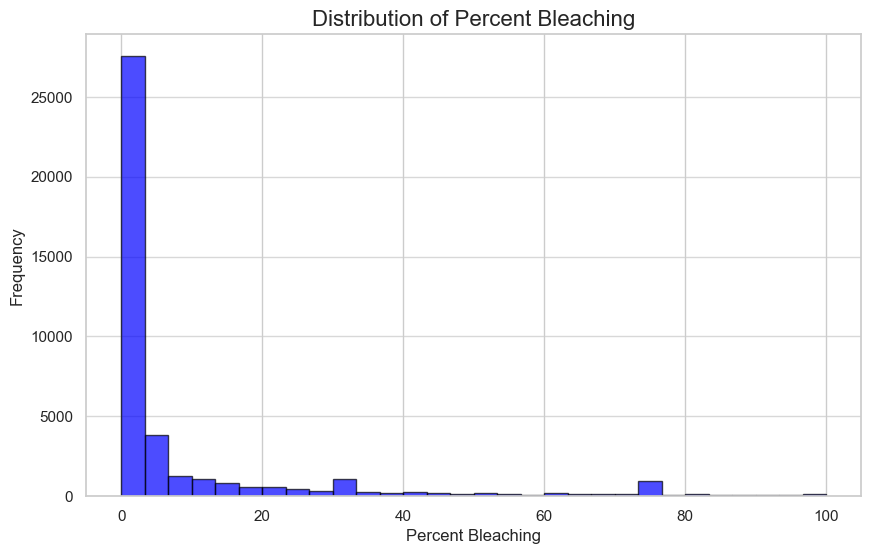

In [475]:
import matplotlib.pyplot as plt

# Plot the Percent_Bleaching column
plt.figure(figsize=(10, 6))
df_filtered['Percent_Bleaching'].dropna().plot(kind='hist', bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Percent Bleaching', fontsize=16)
plt.xlabel('Percent Bleaching', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Find if the data is MAR, MCAR, MNAR


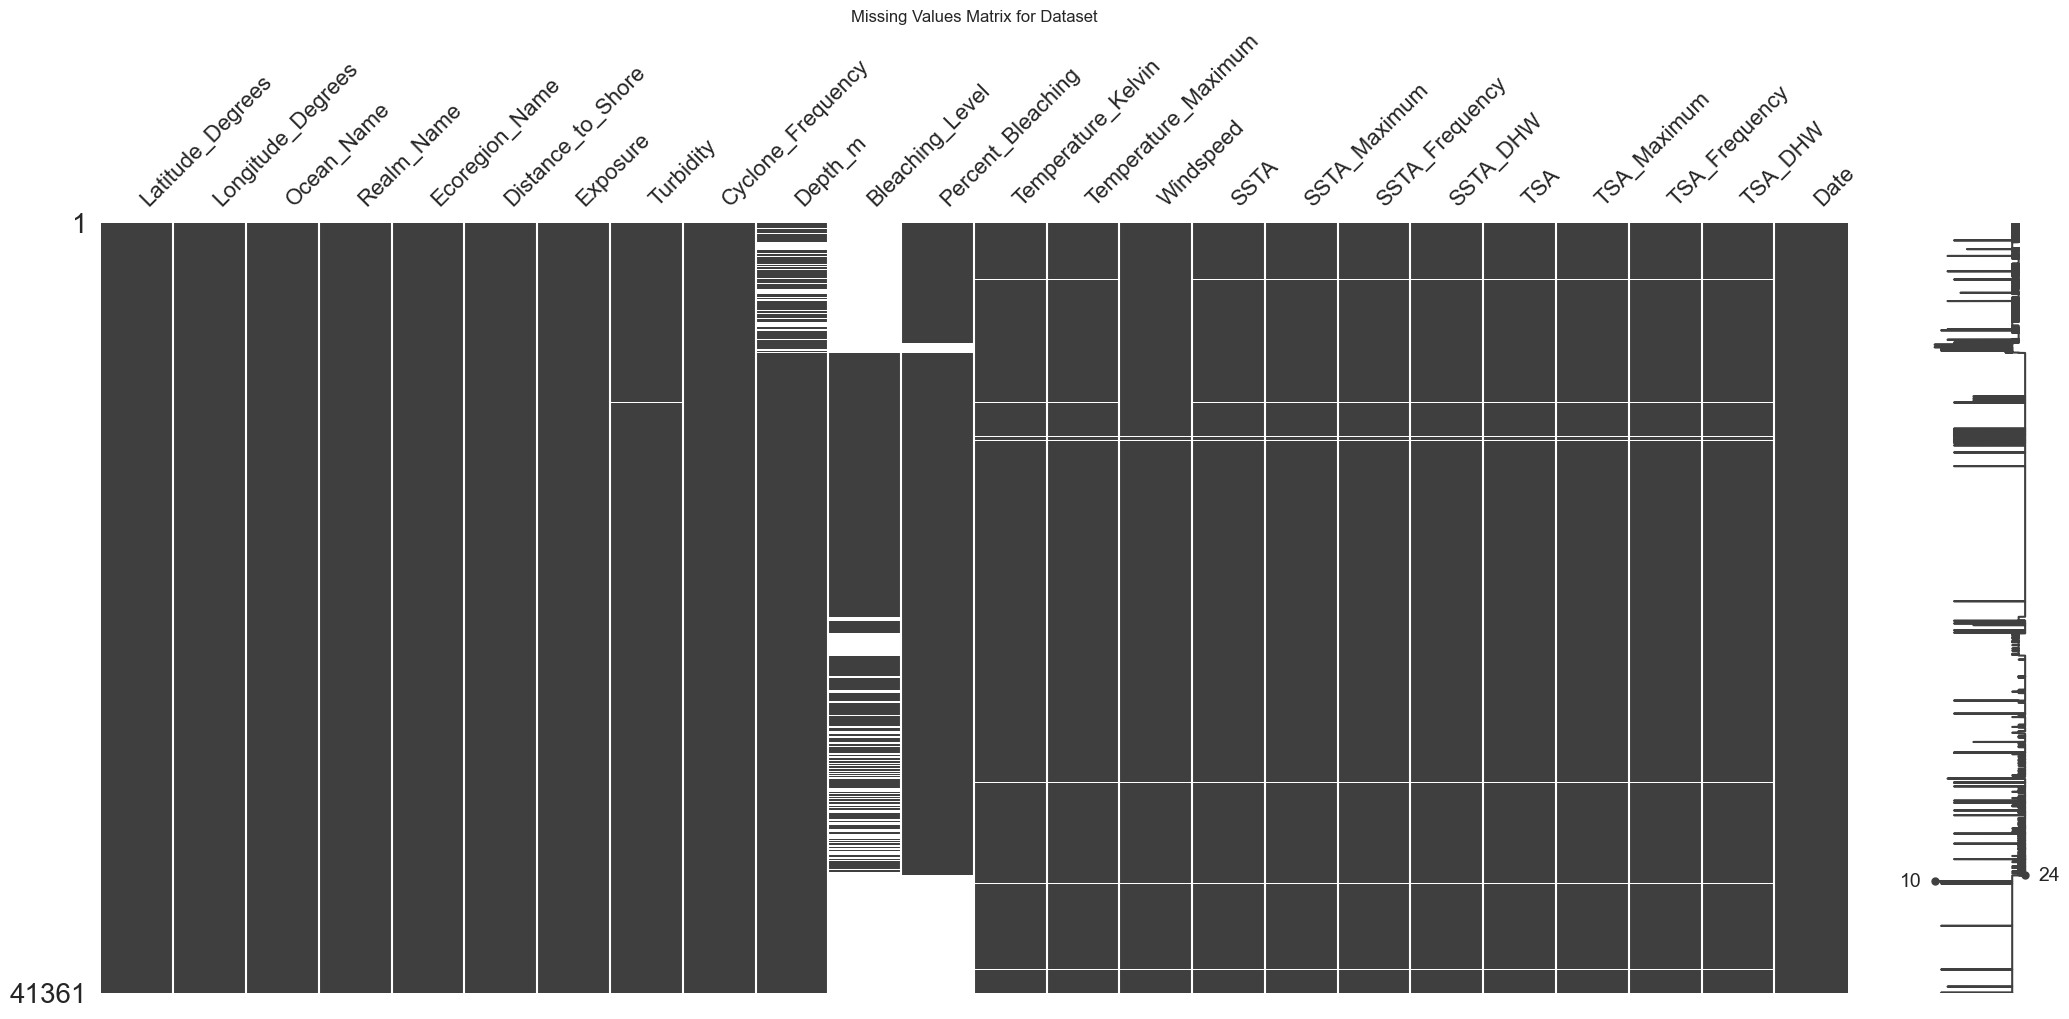

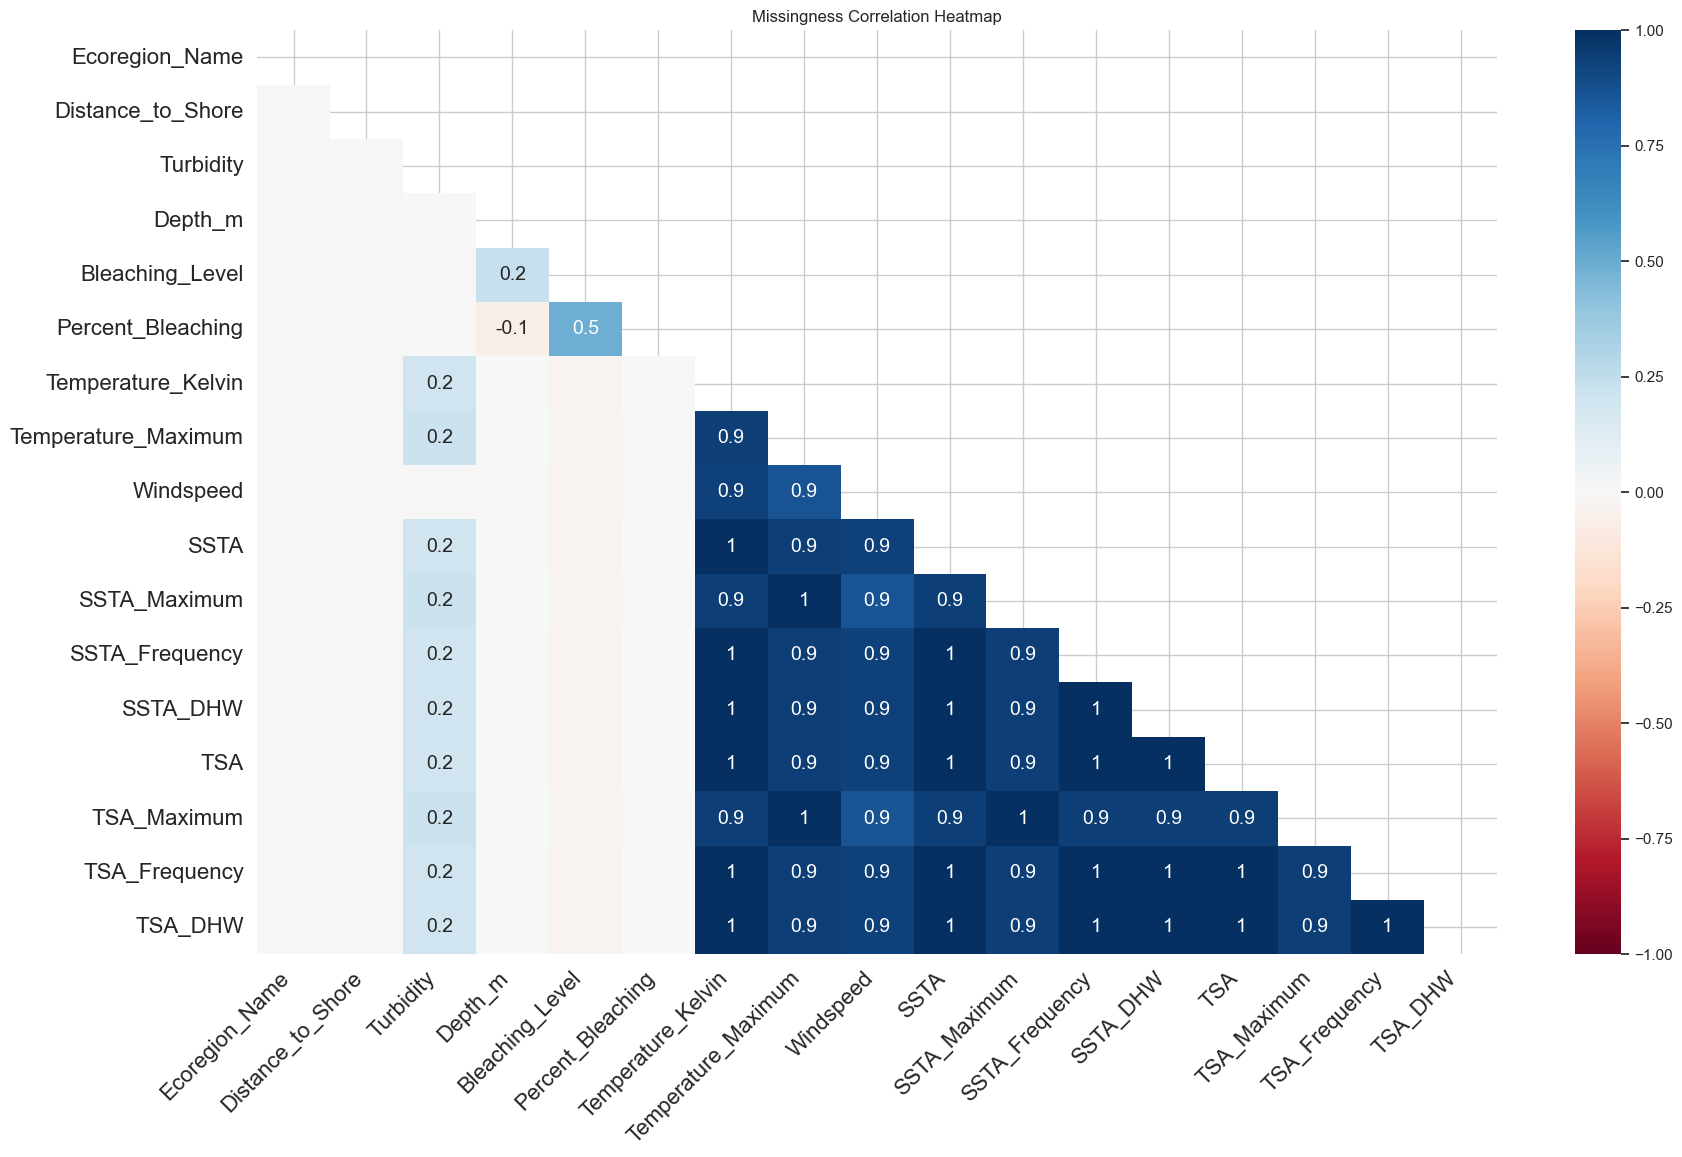

In [480]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(df)
plt.title("Missing Values Matrix for Dataset")
plt.show()

# Visualize correlations in missingness
msno.heatmap(df)
plt.title("Missingness Correlation Heatmap")
plt.show()

Correlation and heatmap indicates the data is Missing at Random (MAR)

#### Correlation matrix

In [481]:
print(df.dtypes)

Latitude_Degrees              float64
Longitude_Degrees             float64
Ocean_Name                   category
Realm_Name                   category
Ecoregion_Name               category
Distance_to_Shore             float64
Exposure                     category
Turbidity                     float64
Cyclone_Frequency             float64
Depth_m                       float64
Bleaching_Level                object
Percent_Bleaching             float64
Temperature_Kelvin            float64
Temperature_Maximum           float64
Windspeed                     float64
SSTA                          float64
SSTA_Maximum                  float64
SSTA_Frequency                float64
SSTA_DHW                      float64
TSA                           float64
TSA_Maximum                   float64
TSA_Frequency                 float64
TSA_DHW                       float64
Date                   datetime64[ns]
dtype: object


In [482]:
# Create missingness indicator for Depth_m
df['Percent_Bleaching_missing'] = df['Percent_Bleaching'].isna().astype(int)

Excluding non numeric columns

In [483]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_with_missingness = numeric_df.corr()['Percent_Bleaching_missing'].sort_values(ascending=False)
print(correlation_with_missingness)


Percent_Bleaching_missing    1.00
Longitude_Degrees            0.16
TSA_Maximum                  0.03
Windspeed                    0.02
SSTA_Maximum                 0.02
Distance_to_Shore            0.01
TSA                         -0.03
Temperature_Maximum         -0.03
TSA_Frequency               -0.03
SSTA_DHW                    -0.04
TSA_DHW                     -0.04
Cyclone_Frequency           -0.05
Temperature_Kelvin          -0.05
Latitude_Degrees            -0.06
SSTA                        -0.07
Depth_m                     -0.07
SSTA_Frequency              -0.07
Turbidity                   -0.30
Percent_Bleaching             NaN
Name: Percent_Bleaching_missing, dtype: float64


Confirming MAR

### Imputation using KNN

In [486]:
from sklearn.impute import KNNImputer

# Selecting relevant features for KNN Imputation, including correlated features
features_for_imputation = [
    "Percent_Bleaching", "Latitude_Degrees", "Longitude_Degrees",
    "Turbidity", "Cyclone_Frequency", "Depth_m", "Temperature_Kelvin", "SSTA",
    "SSTA_Frequency", "TSA"
]

In [487]:
# Extracting relevant subset of the DataFrame for imputation
knn_data = df[features_for_imputation]

# Initializing the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Applying KNN Imputation
imputed_data = knn_imputer.fit_transform(knn_data)

# Updating the original DataFrame with imputed Percent_Bleaching values
df["Percent_Bleaching"] = imputed_data[:, 0]

## For Depth_m

In [488]:
df.isnull().sum()

Latitude_Degrees                 0
Longitude_Degrees                0
Ocean_Name                       0
Realm_Name                       0
Ecoregion_Name                   3
Distance_to_Shore                2
Exposure                         0
Turbidity                        6
Cyclone_Frequency                0
Depth_m                       1799
Bleaching_Level              18830
Percent_Bleaching                0
Temperature_Kelvin             148
Temperature_Maximum            132
Windspeed                      129
SSTA                           148
SSTA_Maximum                   132
SSTA_Frequency                 148
SSTA_DHW                       148
TSA                            148
TSA_Maximum                    132
TSA_Frequency                  148
TSA_DHW                        148
Date                             0
Percent_Bleaching_missing        0
dtype: int64

In [489]:
# Create missingness indicator for Depth_m
df['Depth_m_missing'] = df['Depth_m'].isna().astype(int)

In [490]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_with_missingness = numeric_df.corr()['Depth_m_missing'].sort_values(ascending=False)
print(correlation_with_missingness)

Depth_m_missing              1.00
Percent_Bleaching            0.33
Distance_to_Shore            0.20
TSA_DHW                      0.18
SSTA_DHW                     0.17
TSA_Frequency                0.09
Longitude_Degrees            0.09
SSTA                         0.08
Turbidity                    0.07
TSA                          0.07
TSA_Maximum                  0.05
Windspeed                    0.04
SSTA_Frequency               0.04
Temperature_Kelvin           0.03
SSTA_Maximum                 0.03
Temperature_Maximum         -0.01
Percent_Bleaching_missing   -0.06
Cyclone_Frequency           -0.12
Latitude_Degrees            -0.19
Depth_m                       NaN
Name: Depth_m_missing, dtype: float64


The missingness in Depth_m is most likely MAR (Missing At Random) because:

It is correlated with observed features like Percent_Bleaching and Distance_to_Shore.
There is no evidence to support that the missingness depends on unobserved or missing values of Depth_m.

In [491]:
from sklearn.impute import KNNImputer

features_for_imputation = [
    "Depth_m", "Percent_Bleaching", "Distance_to_Shore", "TSA_DHW",
    "SSTA_DHW", "Turbidity", "Latitude_Degrees", "Longitude_Degrees"
]

knn_data = df[features_for_imputation]

knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(knn_data)

df["Depth_m"] = imputed_data[:, 0]



In [492]:
df.isnull().sum()

Latitude_Degrees                 0
Longitude_Degrees                0
Ocean_Name                       0
Realm_Name                       0
Ecoregion_Name                   3
Distance_to_Shore                2
Exposure                         0
Turbidity                        6
Cyclone_Frequency                0
Depth_m                          0
Bleaching_Level              18830
Percent_Bleaching                0
Temperature_Kelvin             148
Temperature_Maximum            132
Windspeed                      129
SSTA                           148
SSTA_Maximum                   132
SSTA_Frequency                 148
SSTA_DHW                       148
TSA                            148
TSA_Maximum                    132
TSA_Frequency                  148
TSA_DHW                        148
Date                             0
Percent_Bleaching_missing        0
Depth_m_missing                  0
dtype: int64

### For Bleaching Level

Lastly, the null values in the Bleaching_Level column should be replaced with "Colony." According to the column's definition, the levels are either Colony or Population, indicating the scale of bleaching. Replacing the null values with "Colony" is crucial to ensure that any analysis of the Bleaching_Level is more accurate and meaningful.

In [493]:
# Replace NaN values with "Colony" in the 'Bleaching_Level' column
df.fillna({'Bleaching_Level': 'Colony'}, inplace=True)

## Deal with the other missing values

Dropping rows in Columns with values less than 200 as it accounts for less than 0.5 percent of the data

In [494]:
# Identify columns with less than 200 null values
columns_to_consider = df.columns[df.isna().sum() < 200].tolist()

# Drop rows where any of these columns have missing values
df = df.dropna(subset=columns_to_consider)


In [495]:
df.isnull().sum()

Latitude_Degrees             0
Longitude_Degrees            0
Ocean_Name                   0
Realm_Name                   0
Ecoregion_Name               0
Distance_to_Shore            0
Exposure                     0
Turbidity                    0
Cyclone_Frequency            0
Depth_m                      0
Bleaching_Level              0
Percent_Bleaching            0
Temperature_Kelvin           0
Temperature_Maximum          0
Windspeed                    0
SSTA                         0
SSTA_Maximum                 0
SSTA_Frequency               0
SSTA_DHW                     0
TSA                          0
TSA_Maximum                  0
TSA_Frequency                0
TSA_DHW                      0
Date                         0
Percent_Bleaching_missing    0
Depth_m_missing              0
dtype: int64

In [496]:
columns_to_drop = ['Percent_Bleaching_missing', 'Depth_m_missing']

df = df.drop(columns=columns_to_drop, errors='ignore')

In [497]:
df.columns

Index(['Latitude_Degrees', 'Longitude_Degrees', 'Ocean_Name', 'Realm_Name',
       'Ecoregion_Name', 'Distance_to_Shore', 'Exposure', 'Turbidity',
       'Cyclone_Frequency', 'Depth_m', 'Bleaching_Level', 'Percent_Bleaching',
       'Temperature_Kelvin', 'Temperature_Maximum', 'Windspeed', 'SSTA',
       'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_DHW', 'TSA', 'TSA_Maximum',
       'TSA_Frequency', 'TSA_DHW', 'Date'],
      dtype='object')

### Rename Columns

In [498]:
# Rename columns for better readability
df.rename(columns={'Temperature_Kelvin': 'SST', 'Temperature_Maximum': 'SST_Maximum'}, inplace=True)

### Duplicates

Duplicates in a dataset do not add value or new information during analysis, especially in this context. If two rows are exactly the same, it indicates that the same reef at the same location has been sampled multiple times. This redundancy does not contribute additional insights and can even distort the analysis by overrepresenting certain data points.

In ecological studies, where each observation is meant to provide unique information about environmental conditions and coral health, duplicate entries can lead to biased results, such as inflating the perceived impact of certain environmental factors or misleading trends. Therefore, it's essential to identify and remove duplicates to ensure that the analysis is based on truly independent observations, thereby preserving the integrity and accuracy of the results.

In [500]:
df.duplicated().sum()

14380

In [501]:
# Drop duplicate rows
df = df.drop_duplicates(keep='first')

# Reset the index of the dataset
df.reset_index(drop=True, inplace=True)

## Final Dataframe

In [502]:
df.head()

,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Realm_Name,Ecoregion_Name,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Depth_m,...,Windspeed,SSTA,SSTA_Maximum,SSTA_Frequency,SSTA_DHW,TSA,TSA_Maximum,TSA_Frequency,TSA_DHW,Date
0,23.16,-82.53,Atlantic,Tropical Atlantic,Cuba and Cayman Islands,"8,519.23",Exposed,0.03,49.90,10.00,...,8.00,-0.46,2.24,0.00,0.00,-0.80,1.83,0.00,0.00,2005-09-15
1,-17.57,-149.78,Pacific,Eastern Indo-Pacific,Society Islands French Polynesia,"1,431.62",Exposed,0.03,51.20,14.00,...,2.00,1.29,3.10,0.50,0.26,1.29,3.00,0.25,0.26,1991-03-15
2,18.37,-64.56,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,182.33,Exposed,0.04,61.52,7.00,...,8.00,0.04,2.83,16.00,0.00,-2.64,2.31,7.00,0.00,2006-01-15
3,17.76,-64.57,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,313.13,Exposed,0.04,65.39,9.02,...,3.00,-0.07,2.47,22.00,0.00,-2.27,2.19,3.00,0.00,2006-04-15
4,17.77,-64.58,Atlantic,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,792.00,Exposed,0.04,65.39,12.50,...,3.00,0.00,2.30,16.00,0.00,-2.19,1.87,3.00,0.00,2006-04-15


In [503]:
df.columns

Index(['Latitude_Degrees', 'Longitude_Degrees', 'Ocean_Name', 'Realm_Name',
       'Ecoregion_Name', 'Distance_to_Shore', 'Exposure', 'Turbidity',
       'Cyclone_Frequency', 'Depth_m', 'Bleaching_Level', 'Percent_Bleaching',
       'SST', 'SST_Maximum', 'Windspeed', 'SSTA', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_DHW', 'TSA', 'TSA_Maximum', 'TSA_Frequency',
       'TSA_DHW', 'Date'],
      dtype='object')

| **Column Name**        | **Description**                                                      | **Data Type**       | **Unit**                   |
|------------------------|----------------------------------------------------------------------|---------------------|----------------------------|
| `Latitude_Degrees`      | Latitude of the observation point                                   | `float64`           | Degrees                    |
| `Longitude_Degrees`     | Longitude of the observation point                                  | `float64`           | Degrees                    |
| `Ocean_Name`            | Name of the ocean where the observation was made                    | `object`            | N/A                        |
| `Realm_Name`            | Marine biogeographic realm where the observation was made           | `object`            | N/A                        |
| `Ecoregion_Name`        | Ecoregion where the observation was made                            | `object`            | N/A                        |
| `Distance_to_Shore`     | Distance from the shore to the observation point                    | `float64`           | Meters (m)            |
| `Exposure`              | Type of exposure to environmental factors                           | `object`            | Categorical (Sheltered, Exposed, etc.) |
| `Turbidity`             | Water turbidity level (higher values indicate murkier water)        | `float64`           | Index (no unit)            |
| `Cyclone_Frequency`     | Frequency of cyclones in the region                                 | `float64`           | Events per year            |
| `Depth_m`               | Depth of the observation point                                      | `float64`           | Meters (m)                 |
| `Bleaching_Level`       | Categorical variable indicating severity of bleaching               | `object`            | N/A                        |
| `Percent_Bleaching`     | Percentage of coral bleaching observed                              | `float64`           | Percentage (%)             |
| `SST`                   | Sea Surface Temperature at the time of observation                  | `float64`           | Kelvin (K)                 |
| `SST_Maximum`           | Maximum Sea Surface Temperature recorded                            | `float64`           | Kelvin (K)                 |
| `Windspeed`             | Wind speed at the observation point                                 | `float64`           | Meters per second (m/s)    |
| `SSTA`                  | Sea Surface Temperature Anomaly (difference from average SST)       | `float64`           | Kelvin (K)                 |
| `SSTA_Maximum`          | Maximum Sea Surface Temperature Anomaly recorded                    | `float64`           | Kelvin (K)                 |
| `SSTA_Frequency`        | Frequency of sea surface temperature anomalies                      | `float64`           | Events                     |
| `SSTA_DHW`              | Degree Heating Weeks due to Sea Surface Temperature Anomalies       | `float64`           | Degree Heating Weeks (DHW) |
| `TSA`                   | Thermal Stress Anomaly (measure of temperature stress)              | `float64`           | Kelvin (K)                 |
| `TSA_Maximum`           | Maximum Thermal Stress Anomaly recorded                             | `float64`           | Kelvin (K)                 |
| `TSA_Frequency`         | Frequency of Thermal Stress Anomalies                               | `float64`           | Events                     |
| `TSA_DHW`               | Degree Heating Weeks due to Thermal Stress Anomalies                | `float64`           | Degree Heating Weeks (DHW) |
| `Date`                  | Date of the observation                                             | `datetime64[ns]`    | Date                       |

# Continue

In [504]:
summary(df).style.background_gradient(cmap='YlOrBr')

data shape: (26828, 24)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
Latitude_Degrees,float64,0,0.000000,11038,-30.262500,35.305600,9.454160,15.671539,23.163000,-17.575000,18.369000
Longitude_Degrees,float64,0,0.000000,10995,-179.974300,179.964500,18.303623,104.098991,-82.526000,-149.783300,-64.564000
Ocean_Name,category,0,0.000000,5,nan,nan,nan,nan,Atlantic,Pacific,Atlantic
Realm_Name,category,0,0.000000,9,nan,nan,nan,nan,Tropical Atlantic,Eastern Indo-Pacific,Tropical Atlantic
Ecoregion_Name,category,0,0.000000,114,nan,nan,nan,nan,Cuba and Cayman Islands,Society Islands French Polynesia,Hispaniola Puerto Rico and Lesser Antilles
Distance_to_Shore,float64,0,0.000000,12053,3.200000,299218.500000,4132.095514,14535.448483,8519.230000,1431.620000,182.330000
Exposure,category,0,0.000000,3,nan,nan,nan,nan,Exposed,Exposed,Exposed
Turbidity,float64,0,0.000000,1495,0.000000,1.284500,0.067739,0.060452,0.028700,0.026200,0.042900
Cyclone_Frequency,float64,0,0.000000,1739,18.310000,105.800000,52.663017,8.046387,49.900000,51.200000,61.520000
Depth_m,float64,0,0.000000,785,0.000000,90.000000,7.183449,4.434070,10.000000,14.000000,7.000000


In [424]:
df_clean.to_csv('Cleaned_Coral_Data.csv', encoding='utf-8', index=False)